# 階層式分群

概念：把相似的資料兩兩合在一群

圖片取自[*維基百科*](https://en.wikipedia.org/wiki/Hierarchical_clustering)

結束

問題在於：
1. 用什麼方式判斷相似度 i.e. d(a,b)
2. 怎樣的相似度應該合併資料 e.g. min d(a,b) or max d(a,b) 

# 例子：Hierarchical Risk Parity (HRP)

引言：
投資組合中的資產，有些資產彼此相似性高，有些則相似性低，我們可以用階層式分群的方式找出相似的資產群組。

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with pd.HDFStore('C:\\Users\\2022080101\\data\\assets.h5') as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

In [3]:
start = 1988
end = 2017

In [4]:
monthly_returns = prices.loc[f'{start}':f'{end}'].resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.columns.names = ['Ticker']
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 195 entries, MMM to XEL
dtypes: float64(195)
memory usage: 549.7 KB


In [5]:
def get_inverse_var_pf(cov, **kargs):
    """Compute the inverse-variance portfolio""" 
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

以下定義

$d(a,b) = \sqrt{\frac{1}{2}(1-\rho_{ab})}$

In [6]:
def get_distance_matrix(corr):
    """Compute distance matrix from correlation; 
        0 <= d[i,j] <= 1""" 
    return np.sqrt((1 - corr) / 2)

In [7]:
cov = monthly_returns.cov()
corr = monthly_returns.corr()
corr.columns.names=['Ticker']

In [8]:
cov

Ticker,MMM,AOS,ABT,ABMD,ADM,ADBE,ADP,AFL,APD,ALK,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
Ticker,,,,,,,,,,,,,,,,,,,,,
MMM,0.003103,0.001881,0.000582,0.001578,0.001237,0.002122,0.001072,0.001605,0.002182,0.001299,...,0.000790,0.000482,0.001655,0.000819,0.001464,0.002216,0.002527,0.001164,0.001560,0.000662
AOS,0.001881,0.008950,0.000729,0.000961,0.000934,0.001830,0.001005,0.001674,0.002174,0.001562,...,0.000782,0.000337,0.001788,0.001704,0.001612,0.002534,0.003062,0.001678,0.001392,0.000457
ABT,0.000582,0.000729,0.003169,0.000559,0.001050,0.001260,0.000833,0.000940,0.000917,0.000820,...,0.000689,0.000472,0.001210,0.000337,0.000958,0.000827,0.001131,0.000963,0.000607,0.000581
ABMD,0.001578,0.000961,0.000559,0.029386,0.000694,0.004249,0.001361,0.002261,0.002017,0.002267,...,-0.000159,0.000668,0.001591,0.001743,0.001971,0.001661,0.002336,0.004947,0.001131,0.001105
ADM,0.001237,0.000934,0.001050,0.000694,0.006072,0.000648,0.001313,0.001308,0.001666,0.001478,...,0.000896,0.000696,0.001049,0.000944,0.000722,0.001354,0.001534,0.001780,0.001530,0.000975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY,0.002216,0.002534,0.000827,0.001661,0.001354,0.003280,0.001839,0.002764,0.002806,0.002257,...,0.001595,0.000539,0.002904,0.001596,0.002865,0.006342,0.004309,0.002304,0.002490,0.000691
WHR,0.002527,0.003062,0.001131,0.002336,0.001534,0.003833,0.001618,0.003202,0.003430,0.002837,...,0.001493,0.000549,0.003659,0.002120,0.003727,0.004309,0.009795,0.002576,0.002629,0.000715
WMB,0.001164,0.001678,0.000963,0.004947,0.001780,0.004258,0.001648,0.002439,0.002231,0.001612,...,0.000181,0.000675,0.002167,0.001591,0.003362,0.002304,0.002576,0.012834,0.001342,0.002335


In [9]:
corr

Ticker,MMM,AOS,ABT,ABMD,ADM,ADBE,ADP,AFL,APD,ALK,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
Ticker,,,,,,,,,,,,,,,,,,,,,
MMM,1.000000,0.356938,0.185621,0.165260,0.285015,0.284735,0.330700,0.335211,0.547754,0.232473,...,0.223575,0.193163,0.372931,0.210614,0.152555,0.499429,0.458391,0.184408,0.394244,0.194024
AOS,0.356938,1.000000,0.136844,0.059242,0.126690,0.144531,0.182671,0.205902,0.321413,0.164555,...,0.130357,0.079498,0.237194,0.258155,0.098892,0.336279,0.327019,0.156577,0.207055,0.078832
ABT,0.185621,0.136844,1.000000,0.057910,0.239480,0.167235,0.254505,0.194383,0.227704,0.145096,...,0.193146,0.186983,0.269796,0.085929,0.098745,0.184492,0.202978,0.150970,0.151886,0.168595
ABMD,0.165260,0.059242,0.057910,1.000000,0.051930,0.185212,0.136486,0.153452,0.164526,0.131774,...,-0.014606,0.086982,0.116480,0.145717,0.066727,0.121683,0.137661,0.254743,0.092886,0.105205
ADM,0.285015,0.126690,0.239480,0.051930,1.000000,0.062183,0.289675,0.195337,0.299011,0.189057,...,0.181453,0.199226,0.168971,0.173655,0.053782,0.218197,0.198953,0.201633,0.276344,0.204323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY,0.499429,0.336279,0.184492,0.121683,0.218197,0.307797,0.397043,0.403929,0.492807,0.282413,...,0.315865,0.150961,0.457745,0.287222,0.208753,1.000000,0.546706,0.255392,0.440099,0.141749
WHR,0.458391,0.327019,0.202978,0.137661,0.198953,0.289461,0.281079,0.376480,0.484607,0.285644,...,0.237928,0.123670,0.464096,0.307068,0.218551,0.546706,1.000000,0.229723,0.373848,0.118003
WMB,0.184408,0.156577,0.150970,0.254743,0.201633,0.280902,0.250024,0.250525,0.275423,0.141808,...,0.025245,0.132855,0.240152,0.201271,0.172231,0.255392,0.229723,1.000000,0.166779,0.336457


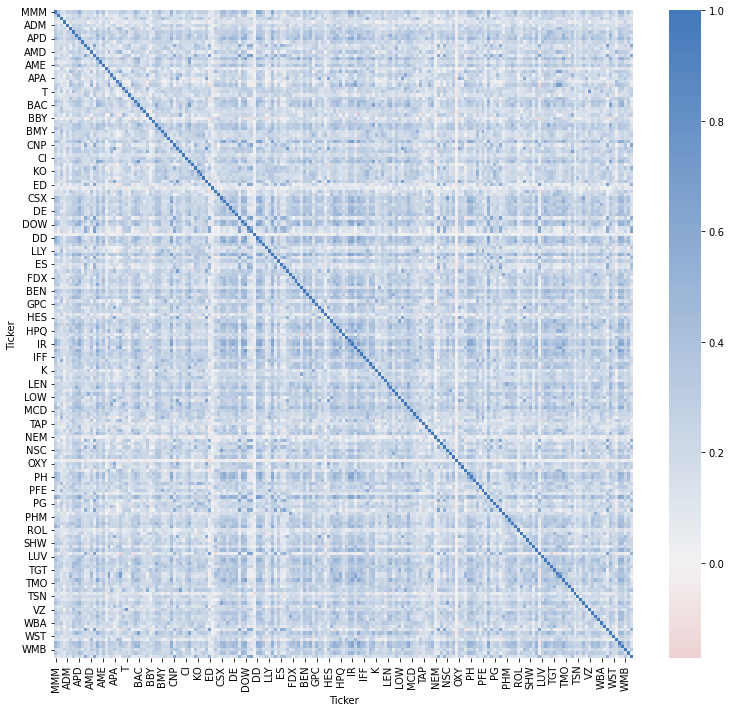

In [10]:
cmap = sns.diverging_palette(10, 250, as_cmap=True) #決定heatmap的顏色
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(corr, center = 0, cmap = cmap, ax=ax) #畫出corr的熱力圖 center指的是cmap的中心
fig.tight_layout()
#tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area. 
#This is an experimental feature and may not work for some cases. 
#It only checks the extents of ticklabels, axis labels, and titles.

In [11]:
distance_matrix = get_distance_matrix(corr)

In [12]:
distance_matrix

Ticker,MMM,AOS,ABT,ABMD,ADM,ADBE,ADP,AFL,APD,ALK,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
Ticker,,,,,,,,,,,,,,,,,,,,,
MMM,0.000000,0.567037,0.638114,0.646042,0.597907,0.598024,0.578490,0.576537,0.475524,0.619487,...,0.623067,0.635153,0.559942,0.628246,0.650940,0.500286,0.520389,0.638589,0.550344,0.634813
AOS,0.567037,0.000000,0.656946,0.685842,0.660799,0.654014,0.639269,0.630118,0.582489,0.646315,...,0.659410,0.678418,0.617578,0.609034,0.671233,0.576073,0.580078,0.649393,0.629661,0.678664
ABT,0.638114,0.656946,0.000000,0.686327,0.616652,0.645277,0.610530,0.634672,0.621408,0.653798,...,0.635159,0.637580,0.604237,0.676044,0.671288,0.638556,0.631277,0.651548,0.651197,0.644750
ABMD,0.646042,0.685842,0.686327,0.000000,0.688502,0.638274,0.657082,0.650595,0.646326,0.658872,...,0.712252,0.675654,0.664650,0.653561,0.683108,0.662690,0.656635,0.610433,0.673466,0.668878
ADM,0.597907,0.660799,0.616652,0.688502,0.000000,0.684769,0.595955,0.634296,0.592026,0.636767,...,0.639745,0.632761,0.644604,0.642785,0.687829,0.625221,0.632869,0.631810,0.601522,0.630744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY,0.500286,0.576073,0.638556,0.662690,0.625221,0.588304,0.549071,0.545926,0.503584,0.598994,...,0.584865,0.651552,0.520699,0.596983,0.628986,0.000000,0.476075,0.610167,0.529103,0.655077
WHR,0.520389,0.580078,0.631277,0.656635,0.632869,0.596045,0.599550,0.558355,0.507638,0.597644,...,0.617281,0.661940,0.517641,0.588614,0.625080,0.476075,0.000000,0.620595,0.559532,0.664077
WMB,0.638589,0.649393,0.651548,0.610433,0.631810,0.599624,0.612363,0.612158,0.601904,0.655054,...,0.698124,0.658462,0.616380,0.631953,0.643338,0.610167,0.620595,0.000000,0.645454,0.575996


In [20]:
squareform(distance_matrix)

array([0.56703705, 0.63811399, 0.64604182, ..., 0.64545359, 0.57599618,
       0.68678972])

squareform(距離矩陣)會回傳距離向量，squareform(距離向量)會回傳距離矩陣

In [23]:
squareform(squareform(distance_matrix))

array([[0.        , 0.56703705, 0.63811399, ..., 0.63858898, 0.55034351,
        0.63481322],
       [0.56703705, 0.        , 0.65694603, ..., 0.64939337, 0.62966057,
        0.67866351],
       [0.63811399, 0.65694603, 0.        , ..., 0.65154809, 0.65119669,
        0.64475   ],
       ...,
       [0.63858898, 0.64939337, 0.65154809, ..., 0.        , 0.64545359,
        0.57599618],
       [0.55034351, 0.62966057, 0.65119669, ..., 0.64545359, 0.        ,
        0.68678972],
       [0.63481322, 0.67866351, 0.64475   , ..., 0.57599618, 0.68678972,
        0.        ]])

In [22]:
(1+194)*194/2

18915.0

In [21]:
squareform(distance_matrix).shape

(18915,)

scipy.cluster.hierarchy.linkage(y, method='single', metric='euclidean', optimal_ordering=False)

y : 1-D condensed distance matrix or a 2-D array of observation vectors <br>
method : 預設為single，詳細參照[**linkage**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) <br>
metric : 原則上不需要改 <br>
optimal_ordering : True代表linkage matrix會把要合併成一群的資料並排，會花很多時間。預設是false

In [25]:
link_1 = linkage(squareform(distance_matrix), 'single')

In [41]:
link_1.shape

(194, 4)

In [26]:
link_2 = linkage(squareform(distance_matrix), 'complete')

In [27]:
link_3 = linkage(squareform(distance_matrix), 'average')

In [28]:
link_4 = linkage(squareform(distance_matrix), 'weighted')

In [29]:
link_5 = linkage(squareform(distance_matrix), 'centroid')

In [31]:
link_6 = linkage(squareform(distance_matrix), 'median')

In [30]:
link_7 = linkage(squareform(distance_matrix), 'ward')

In [38]:
link_1
# 第一、二個index為分群之編碼，
#第三個index表示前兩個元素之分群之距離，第四個index表示新生成分群所包含之元素個數

array([[2.80000000e+01, 4.50000000e+01, 3.56042525e-01, 2.00000000e+00],
       [2.40000000e+01, 1.80000000e+02, 3.56965085e-01, 2.00000000e+00],
       [6.40000000e+01, 1.02000000e+02, 3.65326692e-01, 2.00000000e+00],
       [4.10000000e+01, 5.10000000e+01, 3.67635694e-01, 2.00000000e+00],
       [1.30000000e+01, 6.60000000e+01, 3.71165389e-01, 2.00000000e+00],
       [8.90000000e+01, 1.58000000e+02, 3.81847175e-01, 2.00000000e+00],
       [2.20000000e+01, 1.69000000e+02, 3.84237015e-01, 2.00000000e+00],
       [5.20000000e+01, 1.63000000e+02, 3.85319098e-01, 2.00000000e+00],
       [7.80000000e+01, 1.98000000e+02, 3.88673283e-01, 3.00000000e+00],
       [6.20000000e+01, 1.99000000e+02, 3.92744157e-01, 3.00000000e+00],
       [1.70000000e+02, 2.01000000e+02, 3.93384288e-01, 3.00000000e+00],
       [4.20000000e+01, 1.74000000e+02, 3.95217573e-01, 2.00000000e+00],
       [1.86000000e+02, 2.02000000e+02, 3.97477669e-01, 3.00000000e+00],
       [5.60000000e+01, 1.32000000e+02, 3.99389156e

In [39]:
from scipy.cluster.hierarchy import dendrogram

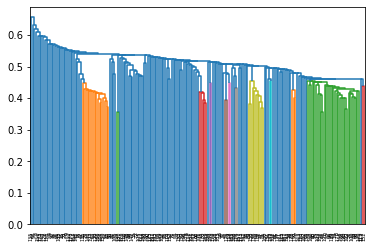

In [40]:
dn = dendrogram(link_1)

In [34]:
link_1.astype(int) #科學記號轉回整數

array([[ 28,  45,   0,   2],
       [ 24, 180,   0,   2],
       [ 64, 102,   0,   2],
       [ 41,  51,   0,   2],
       [ 13,  66,   0,   2],
       [ 89, 158,   0,   2],
       [ 22, 169,   0,   2],
       [ 52, 163,   0,   2],
       [ 78, 198,   0,   3],
       [ 62, 199,   0,   3],
       [170, 201,   0,   3],
       [ 42, 174,   0,   2],
       [186, 202,   0,   3],
       [ 56, 132,   0,   2],
       [190, 197,   0,   3],
       [ 68, 209,   0,   4],
       [146, 210,   0,   5],
       [150, 204,   0,   4],
       [ 39,  69,   0,   2],
       [100, 213,   0,   3],
       [117, 203,   0,   4],
       [187, 195,   0,   3],
       [ 92, 215,   0,   5],
       [171, 211,   0,   6],
       [207, 212,   0,   7],
       [ 73, 214,   0,   4],
       [107, 216,   0,   4],
       [  8, 218,   0,   7],
       [129, 219,   0,   8],
       [ 18, 205,   0,   4],
       [ 57, 220,   0,   5],
       [ 10, 223,   0,   9],
       [101, 224,   0,   5],
       [ 65, 226,   0,  10],
       [ 14, 2

[linkage matrix 裡的解讀方式](https://stackoverflow.com/questions/9838861/scipy-linkage-format)

In [36]:
[link_1[-1, 0], link_1[-1, 1]]

[135.0, 387.0]

In [37]:
link_1[-1, 3]

195.0

In [42]:
def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

In [43]:
distance_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(distance_matrix), 'single')

In [44]:
sorted_idx = quasi_diagonalize(linkage_matrix)

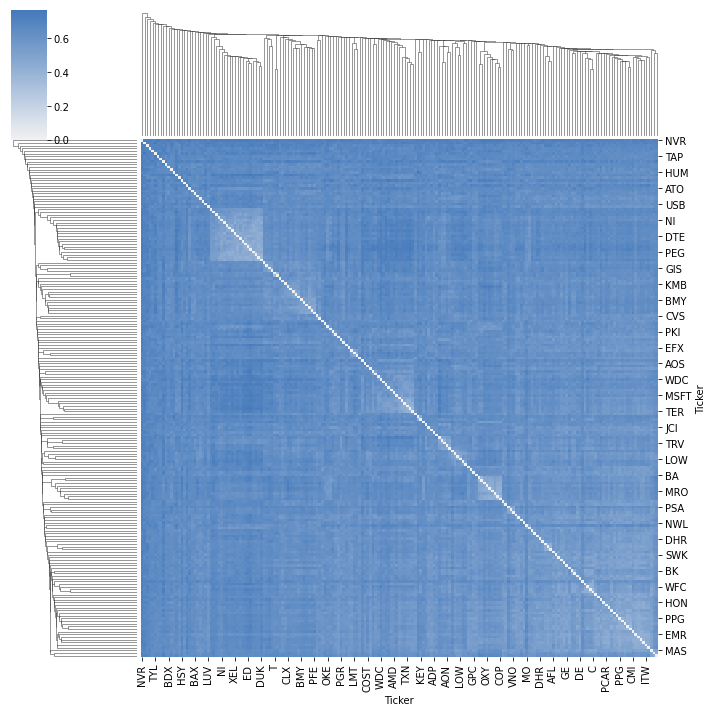

In [45]:
clustergrid = sns.clustermap(distance_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             cmap=cmap, center=0);

In [46]:
sorted_idx = clustergrid.dendrogram_row.reordered_ind

In [47]:
sorted_tickers = corr.index[sorted_idx].tolist()

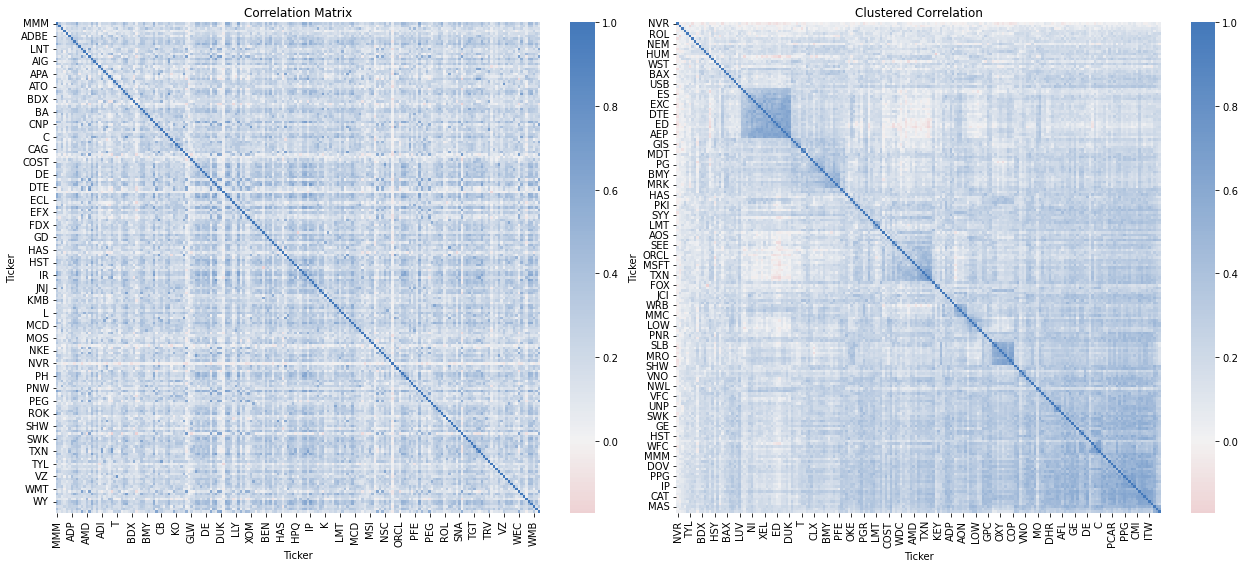

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(corr, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

[**inverse variance weighting**](https://en.wikipedia.org/wiki/Inverse-variance_weighting) <br>
[**hrp algorithm**](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/#:~:text=Inverse%20variance%20%28IVP%29%20has%20assigned%20non-zero%20weights%20to,a%20middle%20ground%20between%20CLA%20and%20IVP%20allocations.)

In [50]:
def get_cluster_var(cov, cluster_items):
    """Compute variance per cluster"""
    cov_ = cov.loc[cluster_items, cluster_items]  # matrix slice
    w_ = get_inverse_var_pf(cov_) #前面定義的函數
    return (w_ @ cov_ @ w_).item() #.item() 返回浮點數資料

In [51]:
# recursive bisection
def get_hrp_allocation(cov, tickers):
    """Compute top-down HRP weights"""

    weights = pd.Series(1, index=tickers)
    clusters = [tickers]  # initialize one cluster with all assets

    while len(clusters) > 0:
        # run bisectional search:
        clusters = [c[start:stop] for c in clusters
                    for start, stop in ((0, int(len(c) / 2)),
                                        (int(len(c) / 2), len(c)))
                    if len(c) > 1]
        for i in range(0, len(clusters), 2):  # parse in pairs
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            cluster0_var = get_cluster_var(cov, cluster0)
            cluster1_var = get_cluster_var(cov, cluster1)

            weight_scaler = 1 - cluster0_var / (cluster0_var + cluster1_var)
            weights[cluster0] *= weight_scaler
            weights[cluster1] *= 1 - weight_scaler
    return weights

In [52]:
hrp_allocation = get_hrp_allocation(cov, sorted_tickers)

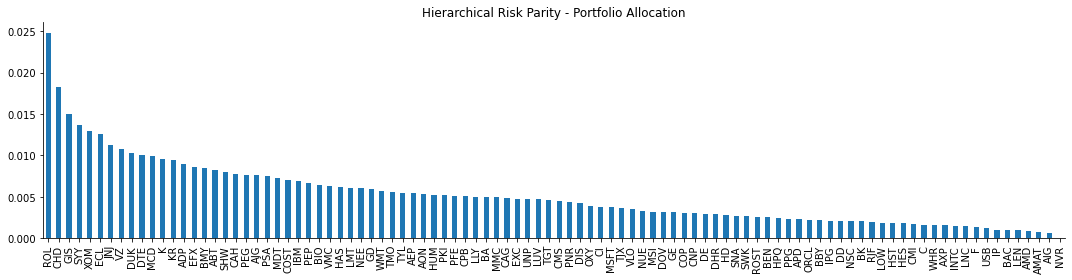

In [53]:
title = 'Hierarchical Risk Parity - Portfolio Allocation'
hrp_allocation.sort_values(ascending=False).iloc[::2].plot.bar(figsize=(15, 4),
                                                               title=title)
sns.despine()
plt.tight_layout()

https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition_Original/blob/master/13_unsupervised_learning/04_hierarchical_risk_parity/01_hierarchical_risk_parity.ipynb<br>
https://zhuanlan.zhihu.com/p/49840457